# Retirement Planner

---

## Environment Setup

In [112]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [113]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [114]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [115]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [116]:
# Display sample data
df.tail()

,AGG,SPY
,close,close
time,,
2019-12-24 00:00:00-05:00,112.375,321.26
2019-12-26 00:00:00-05:00,112.480,322.91
2019-12-27 00:00:00-05:00,112.620,322.86
2019-12-30 00:00:00-05:00,112.630,321.10
2019-12-31 00:00:00-05:00,112.370,321.92


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [117]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
# Display sample data
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [118]:
# Compute daily volatility
avg_daily_return_agg =  daily_returns.mean()['AGG']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']

avg_daily_return_spy = daily_returns.mean()['SPY']['close']
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']

In [119]:
# Save the last day's closing price
agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]

In [120]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

In [121]:
# Run the Monte Carlo Simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 * 30 years
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (40% AGG; 60% SPY)
    weights = [0.40, 0.60]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000476,1.000536,0.998808,1.005394,1.011797,0.994452,0.997251,1.013277,1.000869,0.995376,...,1.002066,0.992709,1.001801,1.002671,0.996472,1.003160,1.001638,1.006800,0.998173,0.994765
2,1.008876,1.004699,1.003590,0.996711,1.009571,0.994247,0.994214,1.007199,1.000225,0.993036,...,1.005759,0.994517,1.003317,1.006181,0.997472,0.991774,1.002764,1.005408,0.996137,0.998871
3,1.008286,1.004228,1.003770,0.998232,1.007751,0.987669,0.998229,1.001361,1.000230,1.001279,...,1.006771,0.988444,1.004118,1.010565,0.993293,0.994454,1.008272,0.999144,0.998656,1.003328
4,1.013963,1.006575,1.008493,1.002636,1.013664,0.990972,1.003241,0.995491,1.002048,1.006036,...,1.004196,0.992123,1.004724,1.004423,0.994844,0.993782,1.005722,1.002248,0.996964,1.004095


In [122]:
simulated_price_df.head()

,AGG prices,SPY prices
0,112.370000,321.920000
1,112.285503,319.272783
2,112.442762,321.170897
3,112.345729,323.744392
4,112.520977,323.820084


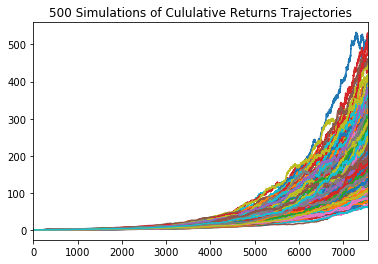

In [61]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cululative Returns Trajectories" 
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [42]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    192.773859
1    171.964137
2    177.998514
3    138.466715
4    175.628015
Name: 7560, dtype: float64

In [144]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    102.825606
0.95    379.341808
Name: 7560, dtype: float64

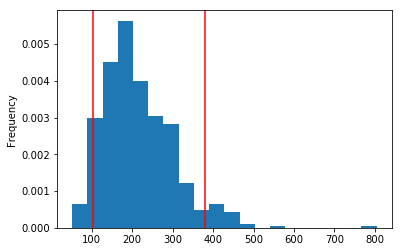

In [52]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [140]:
# Compute cumulative returns
ending_cumulative_returns_90 = ending_cumulative_returns.quantile(0.9)
print(f" Expected cumulative returns at 30 years for 90th percentiles is $" "{:.2f}".format (ending_cumulative_returns_90))

 Expected cumulative returns at 30 years for 90th percentiles is $320.56


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [137]:
# Set initial investment
initial_investment = 20000
# Compute expected portfolio return
returns_90 = initial_investment*ending_cumulative_returns_90
print(f" Expected portfolio returns of $20,000 for 90th percentiles is $" "{:.2f}".format (returns_90))

 Expected portfolio returns of $20,000 for 90th percentiles is $6411230.97


In [141]:
ending_cumulative_returns_10 = ending_cumulative_returns.quantile(0.1)
print(f" Expected cumulative returns at 30 years for 10th percentiles is $" "{:.2f}".format (ending_cumulative_returns_10))

 Expected cumulative returns at 30 years for 10th percentiles is $119.03


In [138]:
# Set initial investment
initial_investment = 20000
# Compute expected portfolio return
returns_10 = initial_investment*ending_cumulative_returns_10
print(f" Expected portfolio returns of $20,000 for 10th percentiles is $" "{:.2f}".format (returns_10))

 Expected portfolio returns of $20,000 for 10th percentiles is $2380549.70


In [142]:
ending_cumulative_returns_50 = ending_cumulative_returns.quantile(0.5)
print(f" Expected cumulative returns at 30 years for 50 percentiles is $" "{:.2f}".format (ending_cumulative_returns_50))

 Expected cumulative returns at 30 years for 50 percentiles is $199.08


In [139]:
# Set initial investment
initial_investment = 20000
# Compute expected portfolio return
returns_50 = initial_investment*ending_cumulative_returns_50
print(f" Expected portfolio returns of $20,000 for 50th percentiles is $" "{:.2f}".format (returns_50))

 Expected portfolio returns of $20,000 for 50th percentiles is $3981677.14


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [163]:
# Set Plaid's projected income:
projected_income = 6085
initial_investment = 20000
# Calculate the 4% withdrawal for the ending return as retirement income
retirement_income = 0.04*(projected_income * ending_cumulative_returns_10)
print(f" Retirement income is $" "{:.2f}".format (retirement_income))

# Determine if the retirement income meets or exceeds the current projected income
print(f" Retirement income is higher than the current projected income")

 Retirement income is $28971.29
 Retirement income is higher than the current projected income


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [ ]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
increase_invest = 30000
returns_increase_90 = 0.04*increase_invest*ending_cumulative_returns_90
print(f" Retirement income with a 50% increase in the initial investment for 90th percentiles is $" "{:.2f}".format (returns_increase_90))


In [161]:
returns_increase_50 = 0.04*increase_invest*ending_cumulative_returns_50
print(f" Retirement income with a 50% increase in the initial investment for 50th percentiles is $" "{:.2f}".format (returns_increase_50))

 Retirement income with a 50% increase in the initial investment for 50th percentiles is $238900.63


In [162]:
returns_increase_10 = 0.04*increase_invest*ending_cumulative_returns_10
print(f" Retirement income with a 10% increase in the initial investment for 90th percentiles is $" "{:.2f}".format (returns_increase_10))

 Retirement income with a 10% increase in the initial investment for 90th percentiles is $142832.98
